In [4]:
from __future__ import division
from models import *
from utils.utils import *
from utils.datasets import *
import os
import sys
import cv2
from PIL import Image
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt


In [5]:
def Convertir_BGR(img):
    # Convertir red, blue, green a Blue, green, red
    img2 = img.copy();
    img2[:, :, 0] = img[:, :, 2]
    img2[:, :, 2] = img[:, :, 0]
    return img2

In [4]:
video = list()
capture = cv2.VideoCapture(0)
for i in range (100):
    valid, frame = capture.read()
    if valid:
        video.append(frame)
capture.release()
video = video [99:100]

clipLimit	Threshold for contrast limiting.
tileGridSize	Size of grid for histogram equalization. Input image will be divided into equally sized rectangular tiles. tileGridSize defines the number of tiles in row and column. 

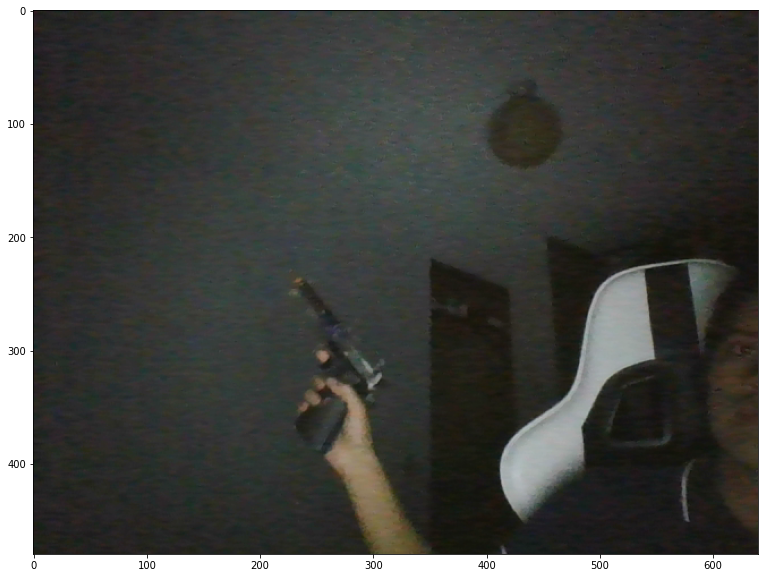

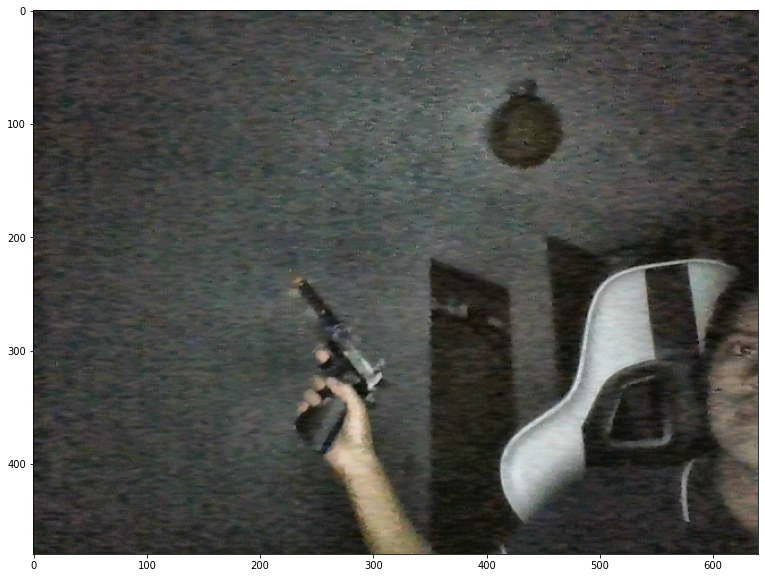

In [139]:
for frame in video:
    #frame_blur = cv2.GaussianBlur(frame,(7,7),8)
    #frame_yuv = cv2.cvtColor(frame,cv2.COLOR_BGR2YUV)
    #frame_yuv[:,:,0] = cv2.equalizeHist(frame_yuv[:,:,0])
    #frame_eq = cv2.cvtColor(frame_yuv, cv2.COLOR_YUV2BGR)

    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(10,10))#1.5, 3 (33) funcionó

    frame_yuv = cv2.cvtColor(frame,cv2.COLOR_BGR2YUV)
    frame_yuv[:,:,0] = clahe.apply(frame_yuv[:,:,0])
    frame_cli = cv2.cvtColor(frame_yuv, cv2.COLOR_YUV2BGR)
    #frame_cli = cv2.GaussianBlur(frame_cli ,(7,7),8) #SIN BLUR, PARA NO PERDER DETALLES DEL BORDE

    frames = [Convertir_BGR(frame), Convertir_BGR(frame_cli)]

    #plt.figure(figsize=(20,10))
    #plt.imshow(Convertir_BGR(frame_eq))
    plt.figure(figsize=(20,10))
    plt.imshow(Convertir_BGR(frame))
    #plt.figure(figsize=(20,10))
    #plt.imshow(Convertir_BGR(frame_cblur))
    plt.figure(figsize=(20,10))
    plt.imshow(Convertir_BGR(frame_cli))

Se detectó arma en X1: 173.6954345703125, Y1: 417.2911376953125, X2: 461.153564453125, Y2: 685.54833984375


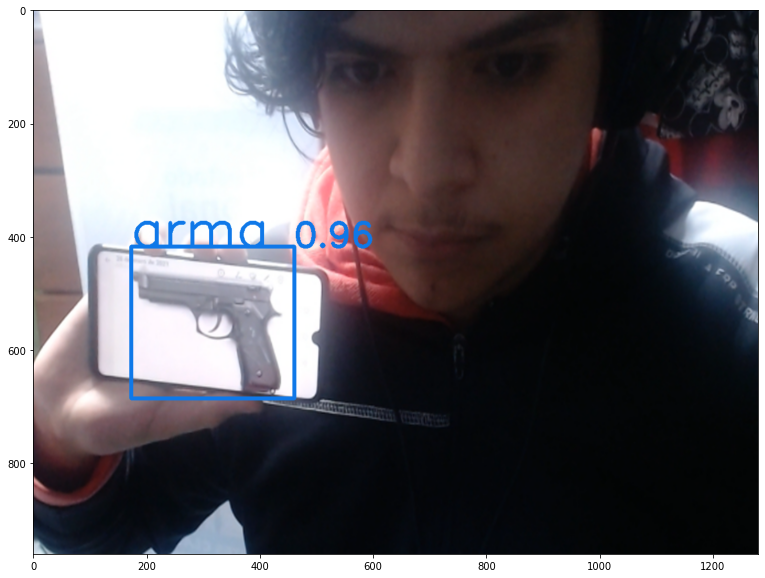

In [7]:
#Configurations
model_def = "config/yolov3-custom.cfg" #model definition file
img_size = 416 #size of images
weights_path = "checkpoints/yolov3_ckpt_24.pth"
conf_thres = 0.50
class_path =  "data/custom/classes.names" 
checkpoint_model = "checkpoints/yolov3_ckpt_24.pth"
nms_thres = 0.4 #iou thresshold for non-maximum suppression


frame = cv2.imread("pistolas.jpg")
#images = frames.copy();
#image = Convertir_BGR(frame_cli)

clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(5,5))#1.5, 3 (33) funcionó

frame_yuv = cv2.cvtColor(frame,cv2.COLOR_BGR2YUV)
frame_yuv[:,:,0] = clahe.apply(frame_yuv[:,:,0])
frame_cli = cv2.cvtColor(frame_yuv, cv2.COLOR_YUV2BGR)
#frame_cli = cv2.GaussianBlur(frame_cli ,(7,7),8) #SIN BLUR, PARA NO PERDER DETALLES DEL BORDE

#images = [Convertir_BGR(frame_cli)]
images = [Convertir_BGR(cv2.imread("AAA.png"))]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("output", exist_ok=True)
model = Darknet(model_def, img_size=img_size).to(device)


if weights_path.endswith(".weights"):
    model.load_darknet_weights(weights_path)
else:
    model.load_state_dict(torch.load(weights_path))

model.eval()  
classes = load_classes(class_path)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

colors = np.random.randint(0, 255, size=(len(classes), 3), dtype="uint8")

for image in images:
    frame_P = cv2.resize(image, (1280, 960), interpolation=cv2.INTER_CUBIC)

    #LA imagen viene en Blue, Green, Red y la convertimos a RGB que es la entrada que requiere el modelo
    #RGBimg=Convertir_BGR(frame)

    imgTensor = transforms.ToTensor()(frame_P)
    imgTensor, _ = pad_to_square(imgTensor, 0)
    imgTensor = resize(imgTensor, 416)
    imgTensor = imgTensor.unsqueeze(0)
    imgTensor = Variable(imgTensor.type(Tensor))


    with torch.no_grad():
        detections = model(imgTensor)
        detections = non_max_suppression(detections, conf_thres, nms_thres)


    for detection in detections:
        if detection is not None:
            detection = rescale_boxes(detection, img_size, frame_P.shape[:2])
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:
                box_w = x2 - x1
                box_h = y2 - y1
                color = [int(c) for c in colors[int(cls_pred)]]
                print("Se detectó {} en X1: {}, Y1: {}, X2: {}, Y2: {}".format(classes[int(cls_pred)], x1, y1, x2, y2))
                frame_P = cv2.rectangle(frame_P, (x1, y1 + box_h), (x2, y1), color, 5)
                cv2.putText(frame_P, classes[int(cls_pred)], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 5)# Nombre de la clase detectada
                cv2.putText(frame_P, str("%.2f" % float(conf)), (x2, y2 - box_h), cv2.FONT_HERSHEY_SIMPLEX, 2,color, 5) # Certeza de prediccion de la clase

        plt.figure(figsize=(20,10))
        plt.imshow(frame_P)